In [111]:
import cell2cell as c2c
import numpy as np
import pandas as pd
import tissue_enrichment_analysis as tea

from collections import defaultdict
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

**Ligand-receptor pairs**

In [6]:
ga_lrs = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv')

In [7]:
bkg_lrs = pd.read_excel('../Data/PPI-Networks/Celegans-Curated-LR-pairs.xlsx')

**RNA-seq data**

In [103]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file='../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx',
                                 gene_column='symbol',
                                 drop_nangenes=True,
                                 log_transformation=False,
                                 format='auto')

Opening RNAseq datasets from ../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


In [104]:
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [105]:
rnaseq_data = rnaseq_data.drop(excluded_cells, axis=1)

**Metadata for cell types**

In [106]:
meta = c2c.io.load_metadata(metadata_file='../Data/RNA-Seq/Celegans_cell_metadata.tsv',
                            rnaseq_data=rnaseq_data,
                            sample_col='#SampleID',
                            format='auto')

../Data/RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


# Enrichment analysis

**Dictionary for converting gene IDs from WormBase into symbol**

In [87]:
mapper = dict(zip(bkg_lrs['Ligand_WB'].values.tolist(), bkg_lrs['Ligand_symbol'].values.tolist()))
mapper.update((zip(bkg_lrs['Receptor_WB'].values.tolist(), bkg_lrs['Receptor_symbol'].values.tolist())))

In [88]:
len(mapper)

190

**Input genes**

In [15]:
id_type = 'WB' # symbol or WB

In [16]:
ga_genes = set(ga_lrs[['Ligand_' + id_type, 'Receptor_' + id_type]].values.flatten().tolist())

In [17]:
bkg_genes = set(bkg_lrs[['Ligand_' + id_type, 'Receptor_' + id_type]].values.flatten().tolist())

**Fetch Phenotypes from WormBase using their tool (tea)**

In [35]:
phenotype = tea.fetch_dictionary('phenotype')

In [36]:
phenotype.set_index('wbid', inplace=True)

Use only genes in our complete list of LR pairs (use them as background genes)

In [37]:
phenotype = phenotype.reindex(bkg_genes)

**Fisher Exact Test**

In [65]:
n = len(ga_genes)
N = len(bkg_genes)

records = []
for c in phenotype.columns:
    phe_df = phenotype[c]
    sam_phe_df = phe_df.reindex(ga_genes)
    
    test_n = sam_phe_df.sum()
    test_N = phe_df.sum()
    test = c2c.stats.enrichment.fisher_representation(n, test_n, N, test_N)
    if N == 0:
        exp = np.nan
    else:
        exp = n/N
    if test_N == 0:
        obs = np.nan
    else:   
        obs = test_n/test_N
    test['fold'] = (exp, obs)
    records.append((c, test['odds'][1], test['pval'][1], *test['fold']))

In [66]:
results = pd.DataFrame.from_records(records, 
                                    columns = ['Term', 
                                               'Enrichment Fold Change', 
                                               'P value', 
                                               'Expected', 
                                               'Observed'])

**Multiple test correction (adjust P-values with FDR Benjamini & Hochberg, and select FDR < 1%)**

In [92]:
fdr = 0.01
results['Q value'] = c2c.stats.compute_fdrcorrection_asymmetric_matrix(results[['P value']], alpha=fdr)
results['logQ'] = -results['Q value'].apply(np.log10)
# remove np.infinites with np.nan
results.logQ.replace([np.inf], np.nan, inplace=True)
# remove np.nan with 70
results.logQ.replace(np.nan, 70, inplace=True)

In [93]:
significant_results = results.loc[results['Q value'] < fdr]
significant_results.sort_values('Q value', ascending=True)

,Term,Enrichment Fold Change,P value,Expected,Observed,Q value,logQ
124,organ system phenotype WBPhenotype:0002554,3.84838,0.000031,0.310526,0.492958,0.007367,2.132714


/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/tissue_enrichment_analysis/hypergeometricTests.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ascending=[True, False], inplace=True)


<AxesSubplot:xlabel='$\\log_{10}{q}$', ylabel='Terms'>

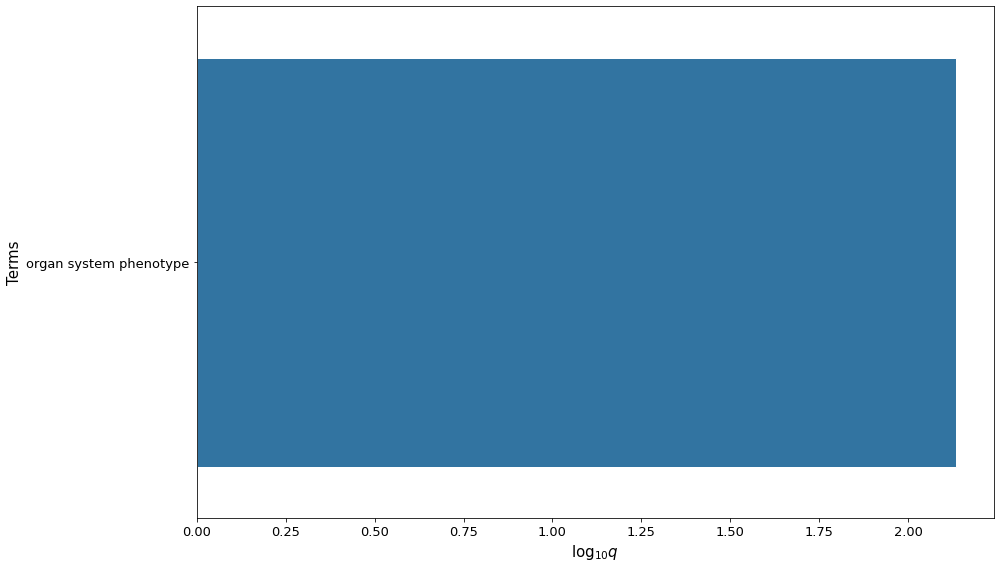

In [94]:
tea.plot_enrichment_results(significant_results, title='Phenotype', analysis='Phenotype', y='logQ', n_bars=10)

**GA selected genes involved**

In [95]:
associated_genes = defaultdict(set)
ga_associated_genes = defaultdict(set)
for idx, row in significant_results.iterrows():
    term = row['Term']
    associated_genes[term] = set([mapper[g] for g in phenotype.loc[phenotype[term] > 0, term].index])
    ga_associated_genes[term] = associated_genes[term] & set([mapper[g] for g in ga_genes])

In [126]:
fraction = len(ga_associated_genes[term]) / len(associated_genes[term])
print('{} is the fraction of genes associated to the enriched phenotype in the complete list of LR pairs and that were \
       selected by the genetic algorithm'.format(np.round(fraction, 2)))

0.49 is the fraction of genes associated to the enriched phenotype in the complete list of LR pairs and that were        selected by the genetic algorithm


# Visualization of presence/absence given gene expression and selected genes

In [107]:
expression = rnaseq_data.gt(10)

In [108]:
# Colors from figure S14 in C elegans paper (cell type expression data)
colors = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
          'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
          'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
          'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
          'Intestine': (1.0, 1.0, 0.2), # Yellow
          'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
          'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
          'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

In [109]:
cell_colors = meta[['#SampleID', 'Groups']].set_index('#SampleID')
cell_colors['Groups'] = cell_colors['Groups'].map(colors)

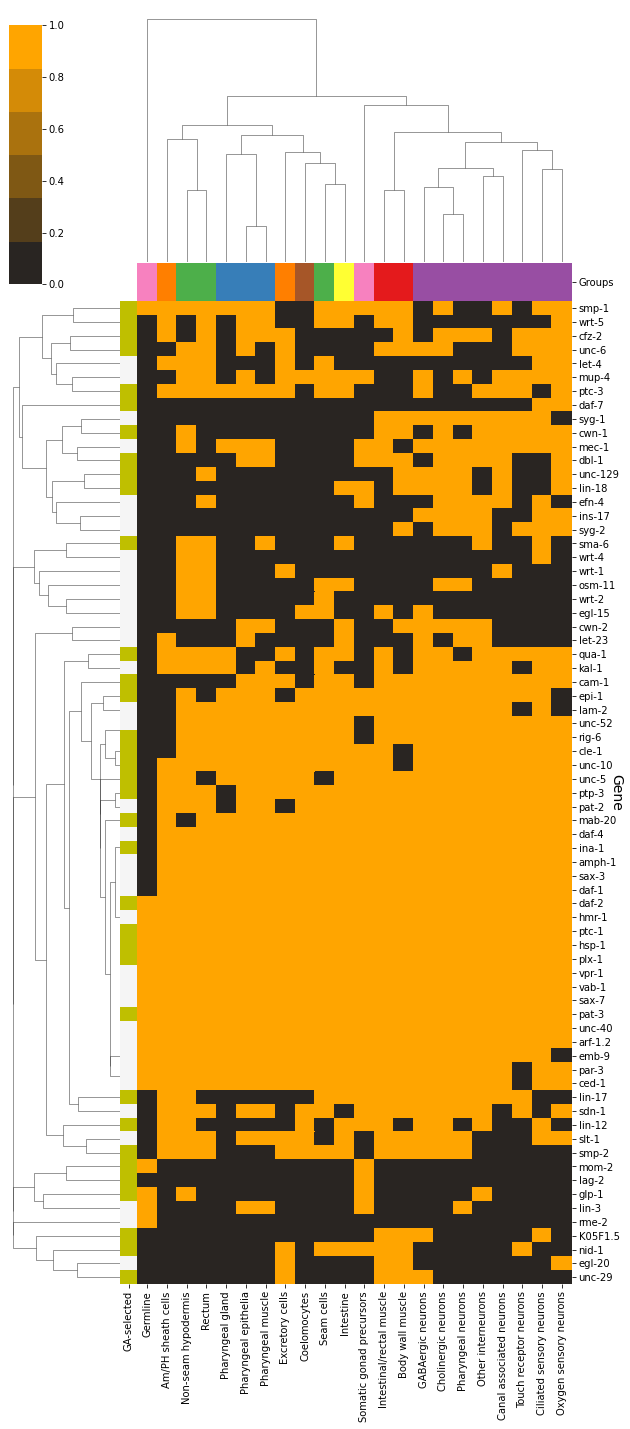

In [120]:
gene_list = associated_genes[term]

colors = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[gene_list],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    row_colors=color_df[['GA-selected']],
                    col_colors=cell_colors,
                    figsize=(9, 20),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))
cm.ax_heatmap.set_ylabel('Gene', fontsize=14, rotation=-90)

plt.savefig('../Figures/Phenotype-Association.svg',
                dpi=300,
                bbox_inches='tight')

Text(635.1999999999999, 0.5, 'Gene')

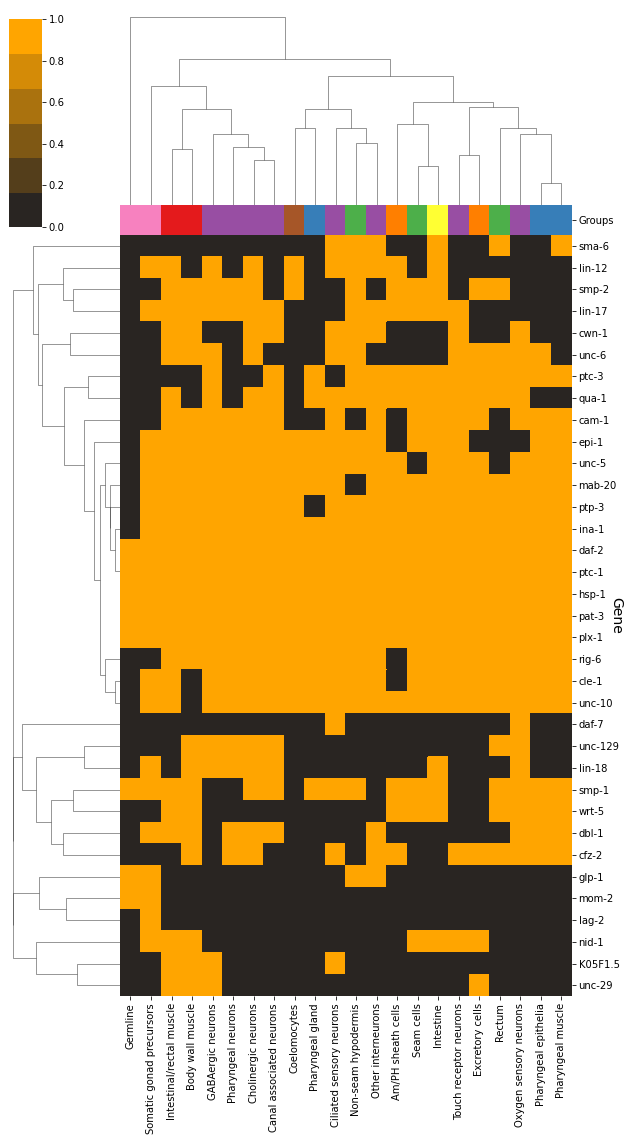

In [122]:
gene_list = associated_genes[term]

colors = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[ga_associated_genes[term]],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    #row_colors=color_df[['GA-selected']],
                    col_colors=cell_colors,
                    figsize=(9, 16),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))
cm.ax_heatmap.set_ylabel('Gene', fontsize=14, rotation=-90)